# 1. **Introduction**
This case study is the ***Capstone Project*** of ***Google Data Analytics Professional Certificate*** . In this case study I am working as a junior data analyst in the marketing analyst team at Cyclistic, a fictional bike-share company in Chicago.

Cyclistic is a bike-share program that features more than 5,800 bicycles and 600 docking stations. Cyclistic sets itself apart by also offering reclining bikes, hand tricycles, and cargo bikes, making bike-share more inclusive to people with disabilities and riders who can’t use a standard two-wheeled bike. The majority of riders opt for traditional bikes; about 8% of riders use the assistive options. Cyclistic users are more likely to ride for leisure, but about 30% use them to commute to work each day.

In 2016, Cyclistic launched a successful bike-share offering. Since then, the program has grown to a fleet of 5,824 bicycles that are geotracked and locked into a network of 692 stations across Chicago. The bikes can be unlocked from one station and returned to any other station in the system anytime.

The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, my team wants to understand how casual riders and annual members use Cyclistic bikes differently. From the insights, our team will design a new marketing strategy to convert casual riders into annual members. But first, Cyclistic executives must approve our recommendations, so they must be backed up with compelling data insights and professional data visualizations.

There are 3 pricing plans: single-ride passes, full-day passes, and annual memberships. Customers who purchase single-ride or full-day passes are referred to as Casual riders. Customers who purchase annual memberships are Cyclistic members.

In order to answer the key business questions, I followed the steps of the data analysis process: ask, prepare, process, analyze, share, and act.

# 2. **Load Data and Quick view**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import re
import os

In [3]:
# Load last 12 month data

from datetime import timedelta
from dateutil import relativedelta

mos = []

for i in range(1,13):
    
    mo = str(datetime.datetime.today() - relativedelta.relativedelta(months= i))\
                                                                    .split()[0][:7]
    mo = re.sub("[ -]", "", mo)
    mos.append(mo)

post_fix = '-divvy-tripdata'
full_data = pd.DataFrame()

for mo in mos:
    temporary_data = pd.read_csv(mo + post_fix + '/' + mo + post_fix + '.csv')
    full_data = pd.concat([full_data, temporary_data])


In [4]:
full_data.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883043 entries, 0 to 756146
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 628.4+ MB


In [7]:
full_data['member_casual'].value_counts(normalize= True)*100

member    0.580408
casual    0.419592
Name: member_casual, dtype: float64

In [8]:
full_data['rideable_type'].value_counts(normalize= True)*100

classic_bike     49.237410
electric_bike    47.227243
docked_bike       3.535347
Name: rideable_type, dtype: float64

In [10]:
full_data['member_casual'].value_counts(normalize= True)*100

member    58.040779
casual    41.959221
Name: member_casual, dtype: float64

# 3. **Cleaning Process**

## Check null data

In [14]:
full_data.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    884365
start_station_id      884363
end_station_name      946303
end_station_id        946303
start_lat                  0
start_lng                  0
end_lat                 5727
end_lng                 5727
member_casual              0
dtype: int64

In [16]:
full_data.loc[full_data['start_station_id'].isnull() == True, ].tail(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
756136,33C493DA143BA13C,electric_bike,2021-09-14 18:34:13,2021-09-14 19:14:35,NaN,NaN,Shore Dr & 55th St,TA1308000009,41.86,-87.64,41.795232,-87.580858,member
756137,DE1A4F1C4F21C881,electric_bike,2021-09-06 12:37:40,2021-09-06 12:59:21,NaN,NaN,N Southport Ave & W Newport Ave,20257.0,41.92,-87.69,41.940000,-87.660000,member
756138,1C07C42BF89342C1,electric_bike,2021-09-13 09:02:40,2021-09-13 09:13:48,NaN,NaN,Ashland Ave & Grand Ave,13434,41.91,-87.69,41.891104,-87.666823,member


- Các dòng thiếu thông tin về các station cũng không quan trọng lắm các dữ liệu cần thiết để tính quãng đường, thời gian đi vẫn đầy đủ -> Không cần remove

## Format Data

In [18]:
# Chuyển các data thời gian về đúng định dạng
full_data['started_at'] = pd.to_datetime(full_data['started_at'])
full_data['ended_at'] = pd.to_datetime(full_data['ended_at'])

In [19]:
full_data.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

## Check duplicate data

In [20]:
full_data['ride_id'] = full_data['ride_id'].str.strip()

full_data.loc[full_data['ride_id'].duplicated() == True ]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


- Không có data bị duplicated

## Data Engineering

#### Calculate ride length

In [21]:
full_data['ride_length'] = (full_data['ended_at'] - full_data['started_at'])/pd.Timedelta(minutes=1)

In [22]:
full_data.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,7.516667
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual,14.033333
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual,10.733333


In [23]:
full_data[full_data['ride_length'] < 1].count()/full_data.shape[0]*100

ride_id               1.881883
rideable_type         1.881883
started_at            1.881883
ended_at              1.881883
start_station_name    1.406738
start_station_id      1.406738
end_station_name      1.253858
end_station_id        1.253858
start_lat             1.881883
start_lng             1.881883
end_lat               1.881713
end_lng               1.881713
member_casual         1.881883
ride_length           1.881883
dtype: float64

- Số lượng các cuốc đi dưới 1p chỉ chiếm 1.8% tổng data -> Ok to remove

In [24]:
full_data = full_data[full_data['ride_length'] >= 1]

### Calculate ride distance

In [25]:
# remove null data end_lat end_lng to calculate distance

full_data.dropna(axis = 0, subset = 'end_lat', inplace= True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\2021983810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data.dropna(axis = 0, subset = 'end_lat', inplace= True)


In [26]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [27]:
import geopy

In [28]:
start_lat = full_data['start_lat'].copy().tolist()
start_lng = full_data['start_lng'].copy().tolist()

end_lat = full_data['end_lat'].copy().tolist()
end_lng = full_data['end_lng'].copy().tolist()


In [29]:
import geopy.distance

In [30]:
  
    ride_distance = []
    
    for i in range(0, len(start_lat)):
        
        start_coords = (start_lat[i], start_lng[i])
        end_coords = (end_lat[i], end_lng[i])

        ride_distance.append(float(geopy.distance.geodesic(start_coords, end_coords).km))


In [31]:
full_data['ride_distance'] = ride_distance

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\1816615119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['ride_distance'] = ride_distance


In [32]:
# Calculate ride speed
full_data['ride_speed'] = full_data['ride_distance']/full_data['ride_length']*60

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\1791037172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['ride_speed'] = full_data['ride_distance']/full_data['ride_length']*60


# 3. **Analyze Data**

## Overview

In [30]:
full_data['member_casual'].value_counts(normalize= True)*100

member    58.040802
casual    41.959198
Name: member_casual, dtype: float64

In [33]:
import calendar

full_data['ride_ym'] = full_data['started_at'].apply(lambda x: str(x).split()[0][0:7])
full_data['ride_hour'] = full_data['started_at'].dt.hour
full_data['ride_weekday'] = full_data['started_at'].apply(lambda x: calendar.day_name[x.weekday()])


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\3558109229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['ride_ym'] = full_data['started_at'].apply(lambda x: str(x).split()[0][0:7])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\3558109229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['ride_hour'] = full_data['started_at'].dt.hour
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17884\3558109229.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [34]:
full_data.head(1)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,ride_distance,ride_speed,ride_ym,ride_hour,ride_weekday
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,7.516667,2.724719,21.749423,2022-08,21,Sunday


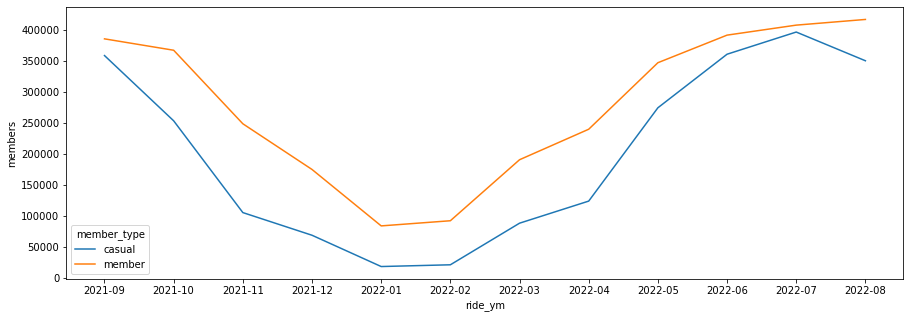

In [35]:
plot_data = full_data.groupby(['ride_ym','member_casual']).size()\
                                        .reset_index()\
                                            .rename(columns={0: 'members', 'member_casual': 'member_type'})

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_ym',
    y = 'members',
    hue = 'member_type',
    data = plot_data,
    ax = ax
)

plt.show()

- Số lượng member luôn nhiều hơn số lượng casual rider
- Vào mùa đông cả member lẫn casual đều ít sử dụng xe đạp tuy nhiên vào giai đoạn mùa hè thì lại có sự tăng trưởng vượt bậc
- Sự tăng giảm của số lượng member lẫn casual có lẽ là chỉ do yếu tố thời vụ chứ không phải do nguyên nhân chủ quan bởi vì cả hai đều cùng tăng cùng giảm

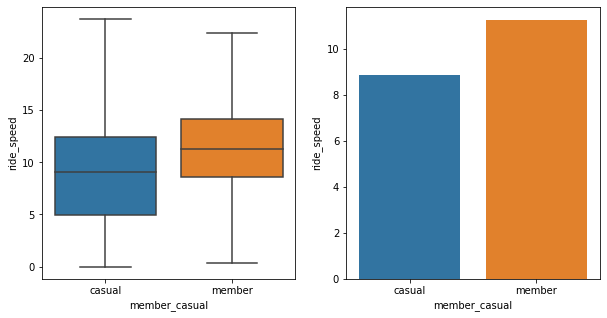

In [ ]:
fig, ax = plt.subplots(1, 2,figsize = (10, 5))

sns.boxplot(
    x = 'member_casual',
    y = 'ride_speed',
    showfliers = False,
    data = full_data,
    ax = ax[0]
)

sns.barplot(
    x = 'member_casual',
    y = 'ride_speed',
    data = full_data.groupby('member_casual')['ride_speed'].mean().reset_index(),
    ax = ax[1]
)

plt.show()

- Member đi với tốc độ nhanh hơn và ổn định hơn so với casual. Trong khi đó casual đi với tốc độ chậm hơn và boxplot của casual có thiên hướng lệch về phía chậm nhiều hơn

- Có lẽ Member sử dụng phương tiện để di chuyển nên cần một tốc độ cao hơn và ổn định hơn?
- Còn member có lẽ sử dụng xe đạp để thư giãn nên không cần phải đi nhanh?

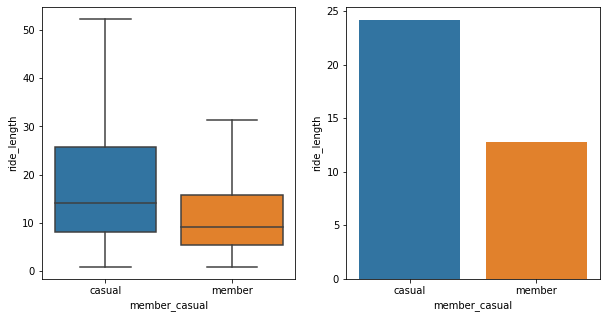

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.boxplot(
    x = 'member_casual',
    y = 'ride_length',
    showfliers = False,
    data = full_data,
    ax = ax[0]
)

sns.barplot(
    x = 'member_casual',
    y = 'ride_length',
    data = full_data.groupby('member_casual')['ride_length'].mean().reset_index(),
    ax = ax[1]
)
plt.show()

- Thời gian di chuyển của casual lâu hơn so với member.
- Thời gian di chuyển tối đa của member chỉ là 30p -> có lẽ là chỉ di chuyển trong nội thành
- Thời gian di chuyển của casual trải dài hơn lên đến tối đa 50p và xu hướng của boxplot cũng phủ rộng thiên về thời gian đường trường nhiều hơn -> Có lẽ là đi thư giãn nên thời gian không cần gấp gáp. Tuy nhiên vẫn có 50% chuyến đi có thời lượng dưới 15p. Maybe vẫn có những người sử dụng xe để di chuyển

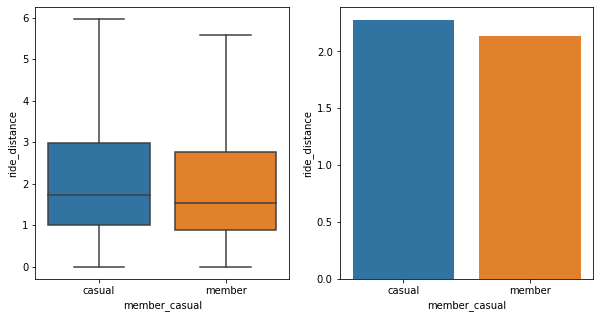

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.boxplot(
    x = 'member_casual',
    y = 'ride_distance',
    showfliers = False,
    data = full_data,
    ax = ax[0]
)

sns.barplot(
    x = 'member_casual',
    y = 'ride_distance',
    data = full_data.groupby('member_casual')['ride_distance'].mean().reset_index(),
    ax = ax[1]
)

plt.show()

- Quãng đường di chuyển của 2 bên khá tương đồng với nhau
- Nhưng tốc dộ của member cao hơn -> member sử dụng xe để di chuyển đến nơi làm việc nên cần tốc độ và thời gian khắt khe hơn, trong khi đó member dùng xe để thư giãn nên tốc độ và thời gian sử dụng cũng thoải mái

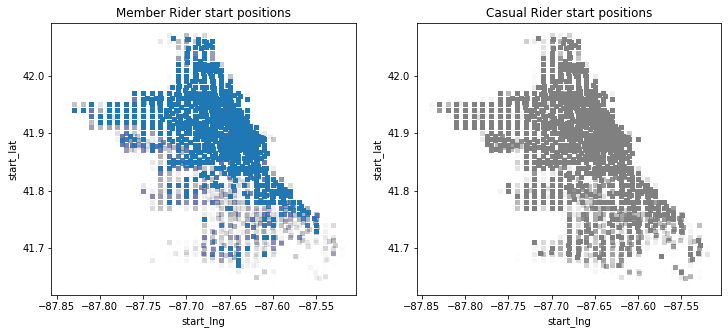

In [66]:


fig, ax = plt.subplots(1,2 ,figsize = (12, 5))

sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    #c = "member_casual",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'member') ],
    ax = ax [0]
)

ax[0].set_title('Member Rider start positions')


sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    color = "grey",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'casual') ],
    ax = ax [1]
)

ax[1].set_title('Casual Rider start positions')

plt.show()

- Nơi tập trung nhiều user chủ yếu là trung tâm Chicago -> Có lẽ sử dụng xe đạp trong nội thành sẽ tiện cho di chuyển hơn
- Tuy nhiên casual rider có một phần tập trung nhiều ở phía nam Chicago hơn -> Có lẽ đây là vùng ngoại ô nên nhiều casual user dùng xe để đi thư giãn do phía nam khu vực dân cư thưa thớt hơn và có nhiều mảng xanh hơn sơ với khu vực trung tâm

<img src="chicago map.png" width="300px">

<AxesSubplot:xlabel='rideable_type', ylabel='rides'>

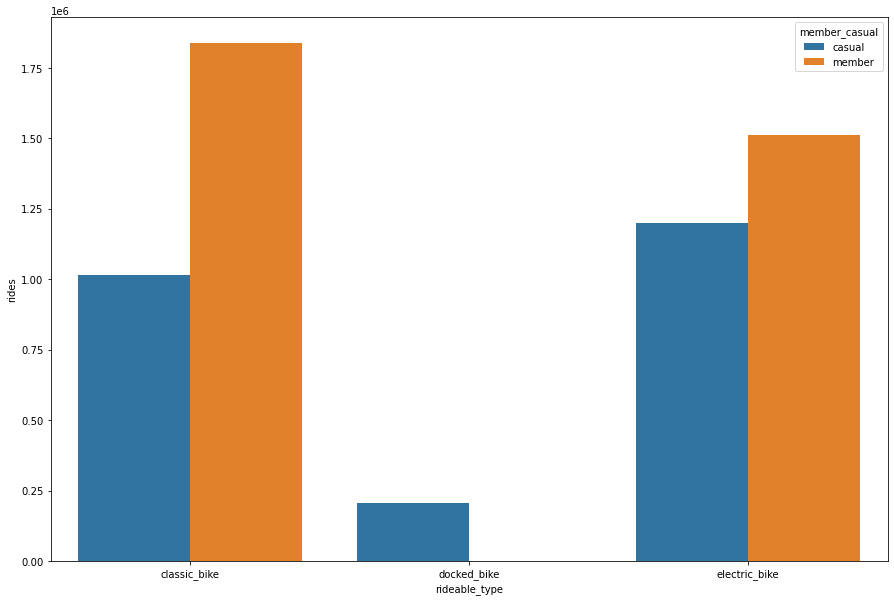

In [70]:
plot_data = full_data.groupby(['member_casual', 'rideable_type']).size\
                                                ().reset_index().rename(columns = {0 : 'rides'})

fig, ax = plt.subplots(figsize = (15, 10))

sns.barplot(
    x = 'rideable_type',
    y = 'rides',
    hue = 'member_casual',
    data = plot_data
)

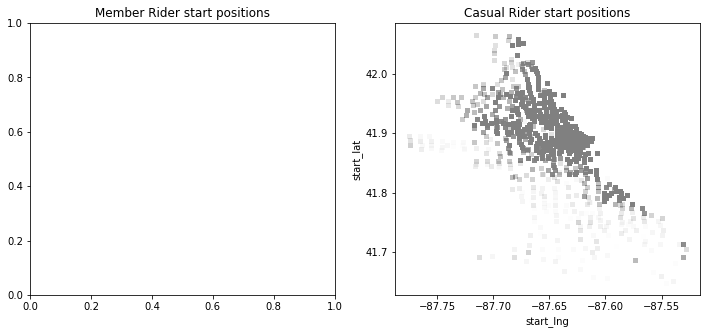

In [73]:


fig, ax = plt.subplots(1,2 ,figsize = (12, 5))

sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    #c = "member_casual",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'member') & (full_data['rideable_type'] == 'docked_bike')],
    ax = ax [0]
)

ax[0].set_title('Member Rider start positions')


sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    color = "grey",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'casual') & (full_data['rideable_type'] == 'docked_bike') ],
    ax = ax [1]
)

ax[1].set_title('Casual Rider start positions')

plt.show()

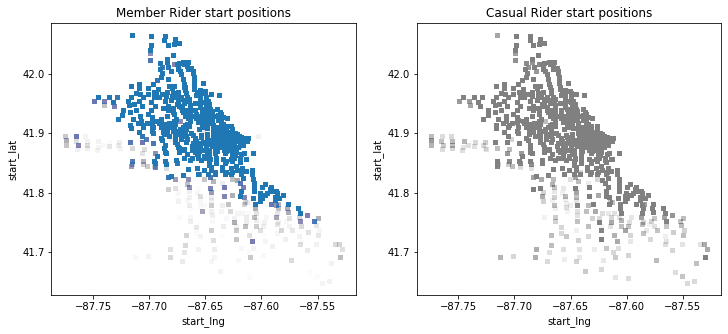

In [74]:


fig, ax = plt.subplots(1,2 ,figsize = (12, 5))

sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    #c = "member_casual",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'member') & (full_data['rideable_type'] == 'classic_bike')],
    ax = ax [0]
)

ax[0].set_title('Member Rider start positions')


sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    color = "grey",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'casual') & (full_data['rideable_type'] == 'classic_bike') ],
    ax = ax [1]
)

ax[1].set_title('Casual Rider start positions')

plt.show()

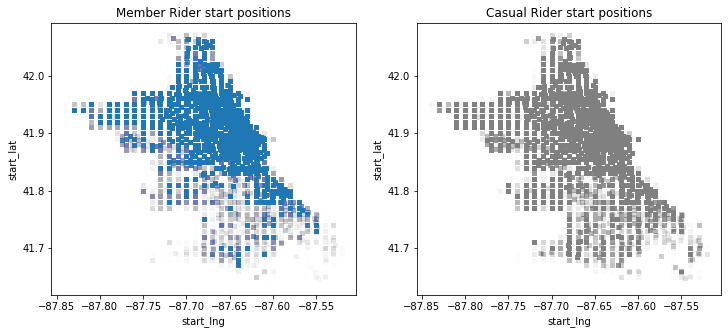

In [75]:


fig, ax = plt.subplots(1,2 ,figsize = (12, 5))

sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    #c = "member_casual",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'member') & (full_data['rideable_type'] == 'electric_bike')],
    ax = ax [0]
)

ax[0].set_title('Member Rider start positions')


sns.scatterplot(
    x = 'start_lng',
    y = 'start_lat',
    alpha = .003,
    
    color = "grey",
     
    cmap = plt.get_cmap("jet"),
    data = full_data.loc[(full_data['start_lat'] < 45) & (full_data['member_casual']  == 'casual') & (full_data['rideable_type'] == 'electric_bike') ],
    ax = ax [1]
)

ax[1].set_title('Casual Rider start positions')

plt.show()

## **Beahaviour in a day**

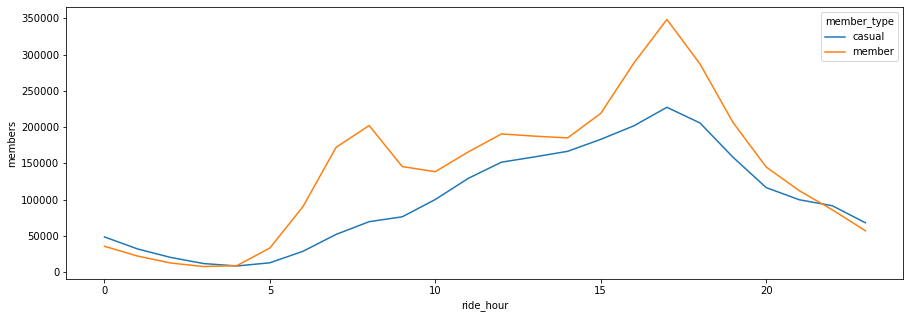

In [40]:
plot_data = full_data.groupby(['ride_hour','member_casual']).size()\
                                        .reset_index()\
                                            .rename(columns={0: 'members', 'member_casual': 'member_type'})

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_hour',
    y = 'members',
    hue = 'member_type',
    data = plot_data,
    ax = ax
)

plt.show()

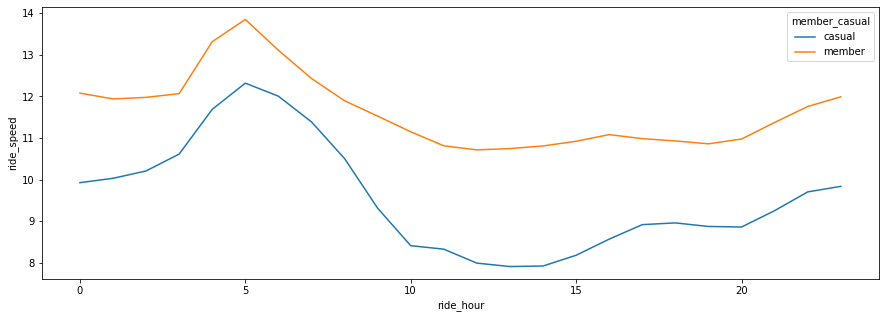

In [41]:
plot_data = full_data.groupby(['ride_hour','member_casual'])['ride_speed'].mean()\
                                        .reset_index()\
                                        

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_hour',
    y = 'ride_speed',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

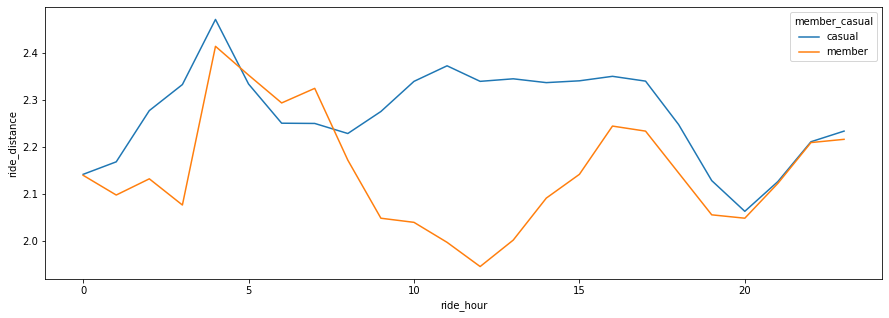

In [42]:
plot_data = full_data.groupby(['ride_hour','member_casual'])['ride_distance'].mean()\
                                        .reset_index()\
                                        

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_hour',
    y = 'ride_distance',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

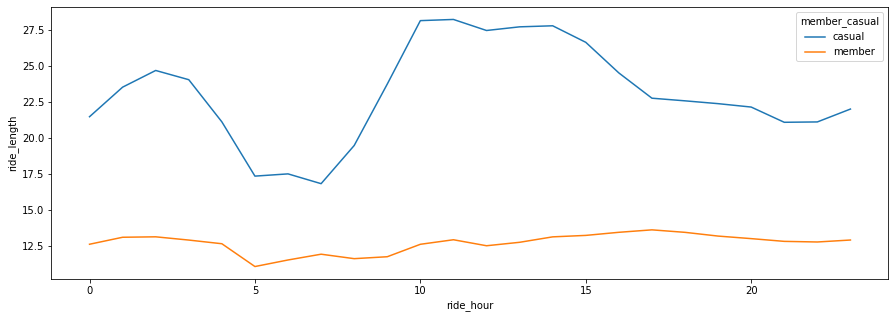

In [43]:
plot_data = full_data.groupby(['ride_hour','member_casual'])['ride_length'].mean()\
                                        .reset_index()\
                                        

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_hour',
    y = 'ride_length',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

### Casual Rider
- Casual rider thích đạp xe buổi sáng và chiều hơn
- Tuy nhiên tốc độ lại khá thấp so với các member (maybe là đạp xe thư giãn)
- Trong khoảng thời gian từ 10h đến 17h thì cả ride length lẫn ride_distance đều cao hơn hẳn member -> khá chắn chắn là đạp xe thư giãn

### Member rider
- Member có 2 đỉnh điểm sử dụng nhiều là buổi sáng và buổi chiều, với buổi chiều cao hơn, maybe là họ dùng xe để đi làm và đi về lúc chiều tối 
- và buổi tối kết hợp với việc đạp xe thư giãn nữa nên tạo 2 peak ở 2 thời điểm này
- Họ đi với tốc độ cao hơn các casual, quãng đường ngắn hơn và với thời gian gần như không đổi giữa các thời điểm -> sure kèo là họ đi làm
trong nội thành nên cần đi nhanh và gấp hơn với thời gian có hạn


## **Behavior in a week**

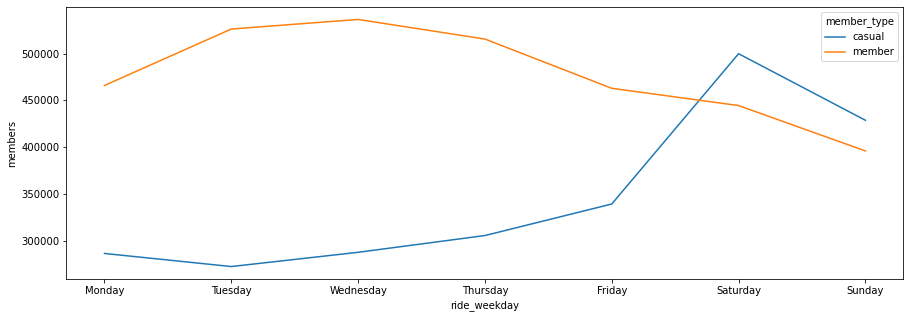

In [44]:
plot_data = full_data.groupby(['ride_weekday','member_casual']).size()\
                                        .reset_index()\
                                            .rename(columns={0: 'members', 'member_casual': 'member_type'})

plot_data['ride_weekday'] = pd.Categorical(plot_data['ride_weekday'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_weekday',
    y = 'members',
    hue = 'member_type',
    data = plot_data,
    sort = True,
    ax = ax
)

plt.show()

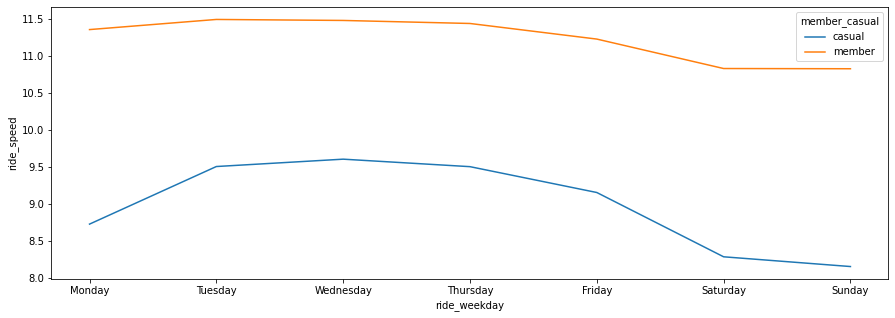

In [45]:
plot_data = full_data.groupby(['ride_weekday','member_casual'])['ride_speed'].mean()\
                                        .reset_index()\
                                        
plot_data['ride_weekday'] = pd.Categorical(plot_data['ride_weekday'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_weekday',
    y = 'ride_speed',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

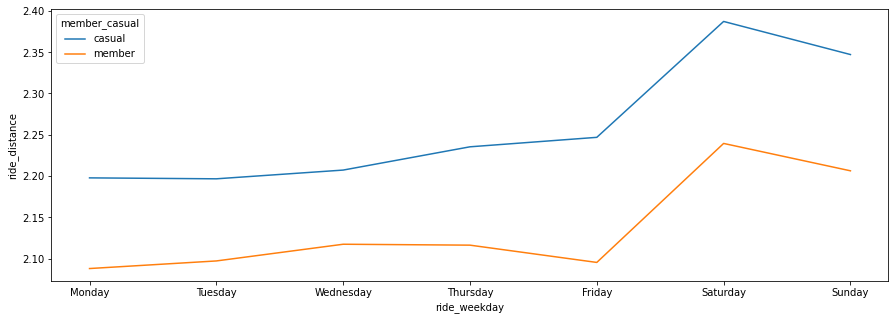

In [46]:
plot_data = full_data.groupby(['ride_weekday','member_casual'])['ride_distance'].mean()\
                                        .reset_index()\
                                        
plot_data['ride_weekday'] = pd.Categorical(plot_data['ride_weekday'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_weekday',
    y = 'ride_distance',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

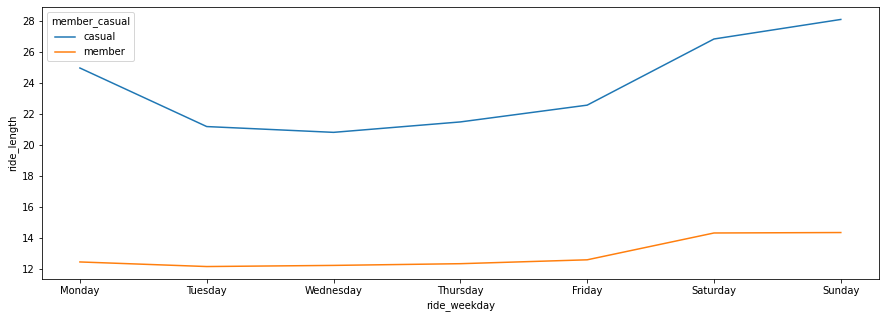

In [47]:
plot_data = full_data.groupby(['ride_weekday','member_casual'])['ride_length'].mean()\
                                        .reset_index()\
                                        
plot_data['ride_weekday'] = pd.Categorical(plot_data['ride_weekday'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(
    x = 'ride_weekday',
    y = 'ride_length',
    hue = 'member_casual',
    data = plot_data,
    ax = ax
)

plt.show()

### Casual Rider

- Casual Rider đi ít hơn trong tuần và tăng đột biến vào cuối tuần. Tăng cả về chiều dài quãng đường và thời gian đi và tốc độ lại giảm
-> thư giãn for sure 
- Trong tuần thì các casual rider vẫn dành một khoảng thời gian và quãng đường duy trì ổn định hằng ngày -> luyện tập sức khỏe hoặc có thể
dùng để đi lại

### Member Rider

- Member thì sử dụng nhiều xe các ngày trong tuần và có xu hướng giảm dần vào cuối tuần. 
- Với tốc độ duy chuyển các ngày trong tuần cũng cao hơn các ngày cuối tuần và cao hơn hẳn các casual
- Quãng đường và thời gian duy chuyển ít hơn các casual (khoảng 100m)

## Conclusions

- Member và Casual đều ít sử dụng xe đạp vào mùa đông và sử dụng nhiều hơn vào mùa hè

- Casual rider có 2 loại:
  
  Sử dụng xe đạp trong tuần để di chuyển hoặc duy trì tập luyện

  Chỉ sử dụng xe đạp vào cuối tuần để thư giãn

- Member sử dụng xe đạp để đi lại trong thành phố (đi làm,...)

# 5. **Reccomendations**

- Đối với các casual rider vẫn duy trì đi lại trong tuần:

Vì lợi ích nhận được của gói annual với casual cũng chỉ là sử dụng xe đạp do đó vấn đề có lẽ nằm ở lợi ích về mặt tài chính khi mà người dùng họ so sánh giữa giá trị gói theo năm và gói theo ngày hoặc theo chuyến không mang lại giá trị bằng

- Giải pháp:

Giới thiệu cho họ về lợi ích của của các gói discount so với gói ngày. Các campaign này nên được tổ chức vào mùa hè khi mà nhu cầu sử dụng sản phẩm tăng cao.

Xây dựng loyalty program cho những khách hàng sử dụng thường xuyên này. Khi đạt đủ điều kiện họ sẽ nhận được discount để mua gói annual.





- Đối với các casual chỉ sử dụng vào cuối tuần:

Offer cho họ gói năm chỉ vào cuối tuần

Vì họ đi để thư giãn thì ta có thể tăng giá trị của dịch vụ ví dụ như kết nối với các cá nhân khác cùng có sở thích đạp xe để đi chung (giống tinder)

